# Machine learning and datasets

In [10]:
import sys
sys.path.insert(0, '../data/')

from matplotlib import pyplot as plt
plt.style.use('acs')

## 1. Know your data

In [2]:
from monty.serialization import loadfn, dumpfn
from pymatgen.io.ase import AseAtomsAdaptor

In [3]:
structure = loadfn("../data/structures/train.json")

In [4]:
structure[0]["structure"]

[Structure Summary
 Lattice
     abc : 10.737580886823372 4.107925405895322 19.675278
  angles : 90.0 90.0 88.37031244373894
  volume : 867.5093669587908
       A : np.float64(10.73655737) np.float64(0.14825364) np.float64(-0.0)
       B : np.float64(0.0601214) np.float64(4.10748543) np.float64(0.0)
       C : np.float64(0.0) np.float64(0.0) np.float64(19.675278)
     pbc : True True True
 PeriodicSite: Cu (9.701, 0.939, 8.661) [0.9025, 0.196, 0.4402]
 PeriodicSite: Cu (4.8, 0.6916, 9.073) [0.4462, 0.1523, 0.4611]
 PeriodicSite: Cu (5.709, 2.699, 8.476) [0.5282, 0.638, 0.4308]
 PeriodicSite: Cu (1.994, 0.8957, 10.8) [0.1845, 0.2114, 0.5487]
 PeriodicSite: Cu (8.929, 2.706, 10.16) [0.8282, 0.629, 0.5164]
 PeriodicSite: Cu (6.342, 2.152, 10.59) [0.5879, 0.5028, 0.5381]
 PeriodicSite: Cu (7.331, 0.8209, 8.828) [0.6819, 0.1752, 0.4487]
 PeriodicSite: Cu (7.498, 0.1231, 11.12) [0.6983, 0.004763, 0.5652]
 PeriodicSite: Cu (4.813, 0.3426, 11.62) [0.4479, 0.06724, 0.5906]
 PeriodicSite: O (9.6

In [ ]:
structure[0]["energy_per_atom"]

In [67]:
energies = [s["energy_per_atom"] for s in structure]

In [123]:
forces = [np.linalg.norm(f) for s in structure for f in s["force"]]

In [77]:
stress = np.array([s["stress"] for s in structure]).reshape(len(energies), 9)

In [5]:
xyz_collection = [AseAtomsAdaptor.get_atoms(s["structure"][0]) for s in structure]

### 1.1 Number of atoms distributions 

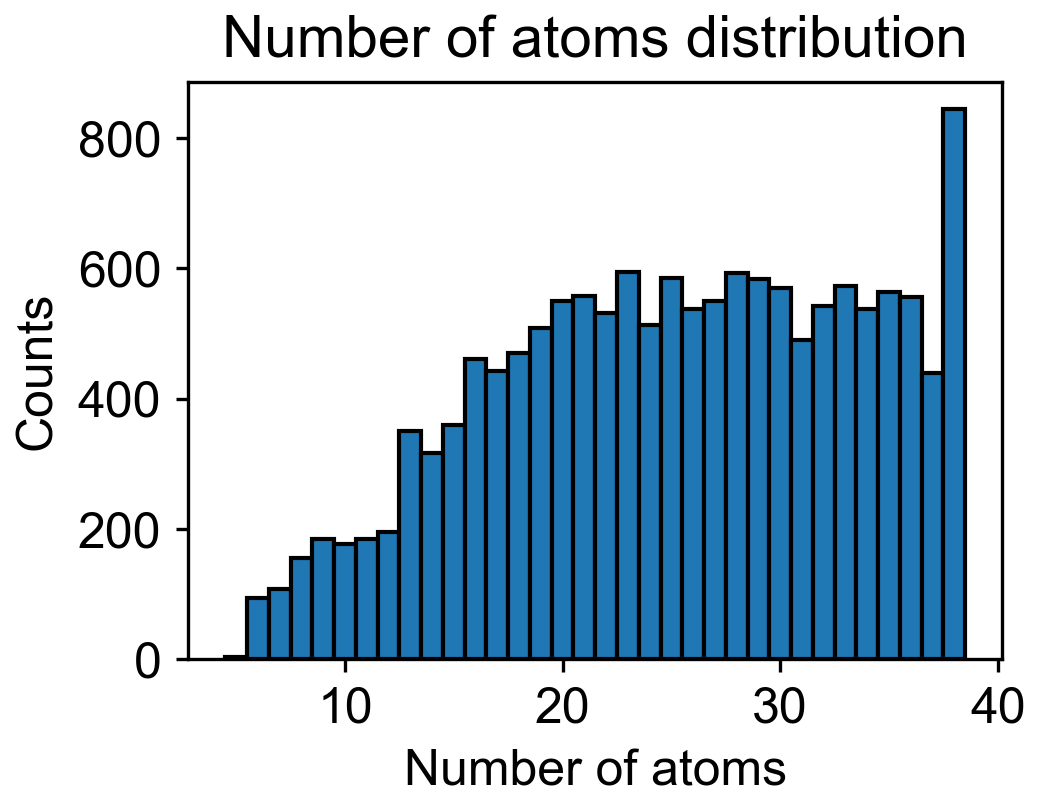

In [ ]:
import numpy as np
from ml.ml_statistic import get_histogram
num_atoms = np.array([len(xyz) for xyz in xyz_collection])


hist, bin_edges = get_histogram(num_atoms, bin_size=1)
plt.bar(bin_edges[:-1], hist, width=1, edgecolor="k")
plt.xlabel("Number of atoms")
plt.ylabel("Counts")
plt.title("Number of atoms distribution")
plt.show()


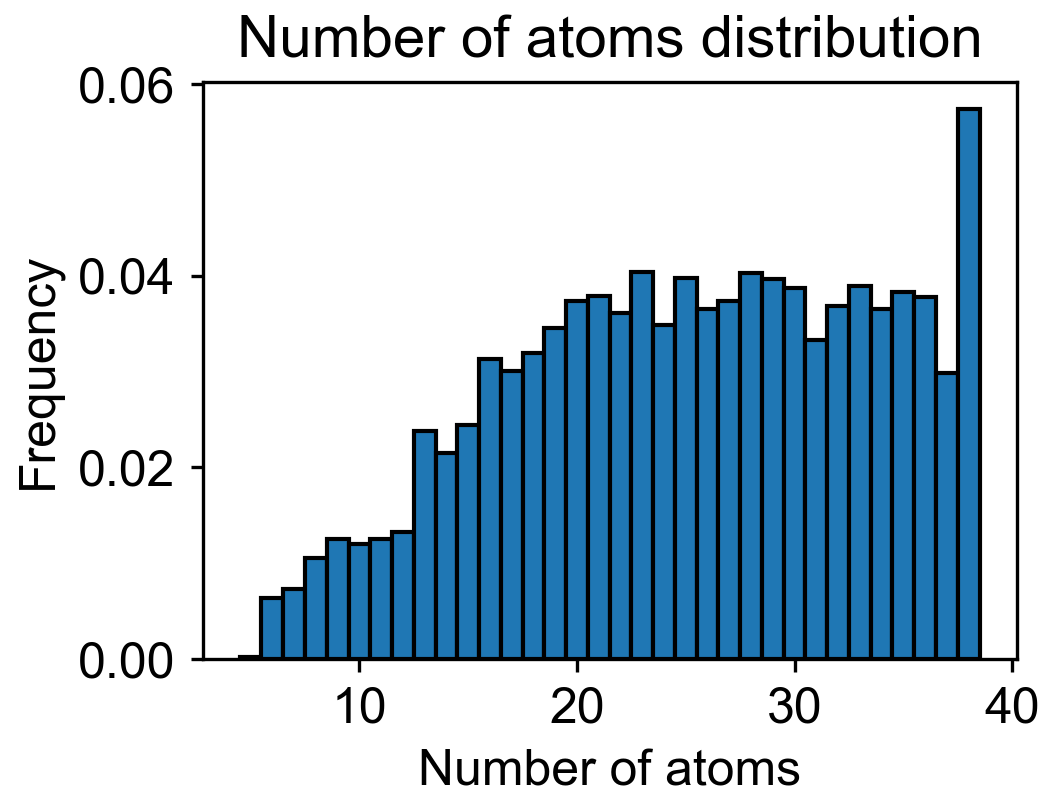

In [13]:
import numpy as np
from ml.ml_statistic import get_histogram
num_atoms = np.array([len(xyz) for xyz in xyz_collection])


hist, bin_edges = get_histogram(num_atoms, bin_size=1)
plt.bar(bin_edges[:-1], hist/len(num_atoms), width=1, edgecolor="k")
plt.xlabel("Number of atoms")
plt.ylabel("Frequency")
plt.title("Number of atoms distribution")
plt.show()


### Energy distribution

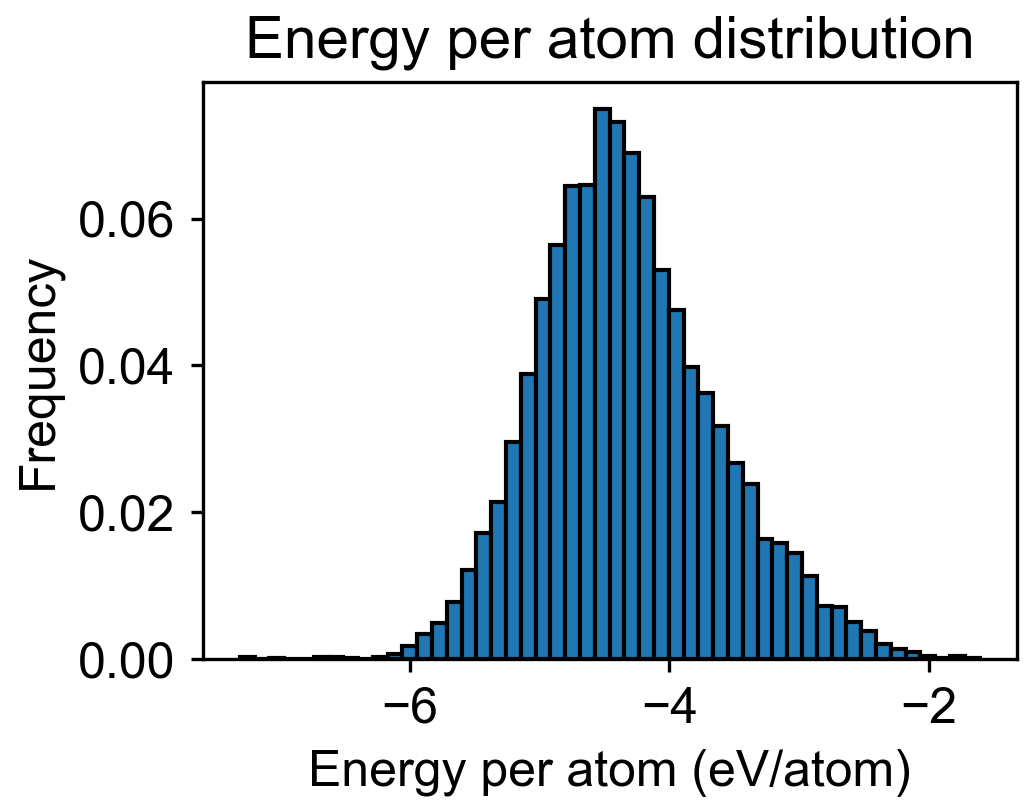

In [88]:
hist, bins = np.histogram(energies, bins=50)
plt.bar(bins[:-1], hist/len(energies), width=(bins[1]-bins[0]), edgecolor="k")
plt.xlabel("Energy per atom (eV/atom)")
plt.ylabel("Frequency")
plt.title("Energy per atom distribution")
plt.show()

### Forces distribution

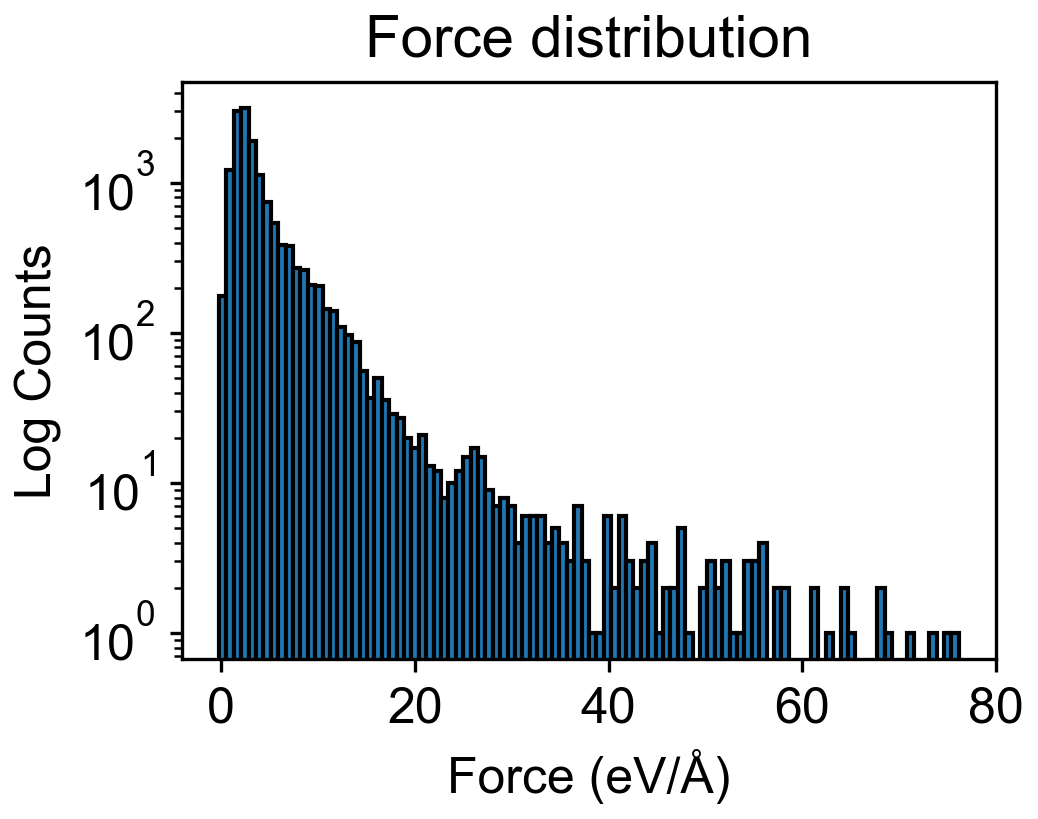

In [124]:
hist, bins = np.histogram(np.hstack(forces), bins=100)
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), edgecolor="k")
plt.yscale("log")
plt.xlabel("Force (eV/Å)")
plt.ylabel("Log Counts")
plt.title("Force distribution")
plt.show()

### Element distribution

In [25]:
element_list = np.hstack([s.numbers for s in xyz_collection])
unique, counts = np.unique(element_list, return_counts=True)

Text(0.5, 1.0, 'Element distribution')

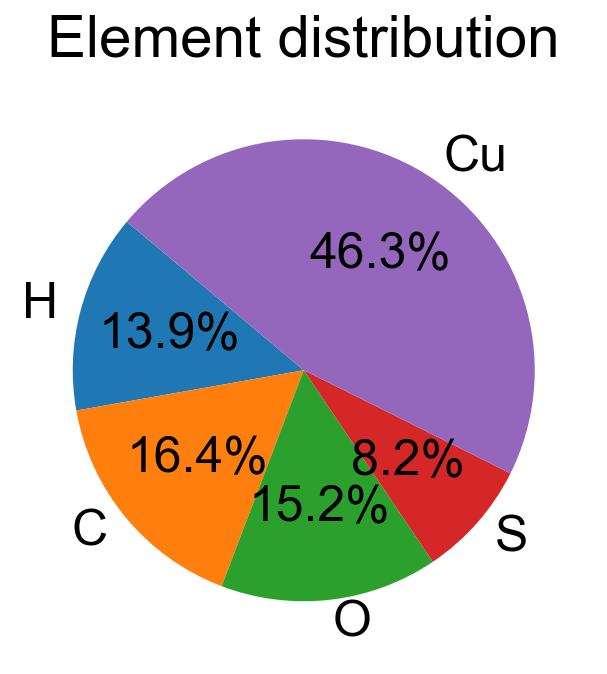

In [36]:
from ase.data import chemical_symbols
plt.pie(counts, labels=[chemical_symbols[i] for i in unique], autopct="%1.1f%%", startangle=140)
plt.title("Element distribution")

## Descriptors

### More Details about SOAP (Smooth Overlap of Atomic Positions)

**Development and Motivation:**  
SOAP was developed to provide a mathematically rigorous, continuous, and differentiable way to describe atomic environments for machine learning in materials science and chemistry. It overcomes limitations of earlier descriptors by ensuring invariance to rotation, translation, and permutation, and by capturing both radial and angular correlations among atoms.

**Atomic Density Expansion:**  
The atomic environment around a central atom is represented by a smooth atomic density:

$$
\rho(\mathbf{r}) = \sum_{i} \exp\left(-\frac{|\mathbf{r} - \mathbf{r}_i|^2}{2\sigma^2}\right)
$$

- $\mathbf{r}_i$: Position of neighboring atom $i$.
- $\sigma$: Width of the Gaussian, controls the smoothness.
- This equation creates a continuous density field from discrete atomic positions, making the descriptor differentiable and robust to small perturbations.

**Basis Expansion:**  
The density $\rho(\mathbf{r})$ is expanded in a basis of radial functions $g_n(r)$ and spherical harmonics $Y_{lm}(\hat{r})$:

$$
\rho(\mathbf{r}) = \sum_{nlm} c_{nlm} \, g_n(r) Y_{lm}(\hat{r})
$$

- $g_n(r)$: Radial basis functions, capture how density varies with distance.
- $Y_{lm}(\hat{r})$: Spherical harmonics, capture angular information.
- $c_{nlm}$: Expansion coefficients, which are the actual SOAP features.

**SOAP Power Spectrum:**  
The descriptor is constructed from the expansion coefficients:

$$
p_{nn'l} = \sum_{m} c_{nlm} \, c^*_{n'lm}
$$

- $p_{nn'l}$: SOAP power spectrum, the final descriptor vector.
- This step ensures rotational invariance by summing over $m$.

**SOAP Kernel:**  
To compare two environments $\mathcal{X}$ and $\mathcal{X}'$, the SOAP kernel is defined as:

$$
k(\mathcal{X}, \mathcal{X}') = \left| \int d\hat{R} \left\langle \rho_{\mathcal{X}} | \hat{R} \rho_{\mathcal{X}'} \right\rangle \right|^\zeta
$$

- $\left\langle \rho_{\mathcal{X}} | \hat{R} \rho_{\mathcal{X}'} \right\rangle$: Overlap between the densities, after rotating one environment.
- $\int d\hat{R}$: Integration over all possible rotations, ensures rotational invariance.
- $\zeta$: Exponent to tune sensitivity (usually 1 or 2).

**Physical Meaning:**  
- The SOAP descriptor encodes how similar two atomic environments are, considering both the arrangement and types of atoms.
- It is sensitive to subtle changes in geometry and composition, making it ideal for regression/classification tasks in atomistic simulations.

**Applications:**  
- Used in kernel-based machine learning (e.g., kernel ridge regression, Gaussian process regression).
- Predicts properties like energy, forces, and chemical reactivity.
- Facilitates clustering, dimensionality reduction, and visualization of atomic environments.

**References:**  
- Bartók, A. P., Kondor, R., & Csányi, G. (2013). On representing chemical environments. *Physical Review B*, 87(18), 184115.
- DScribe documentation: https://singroup.github.io/dscribe/latest/tutorials/soap.html

In [ ]:
from dscribe.descriptors import SOAP
soap = SOAP(
    species=["Cu", "S", "C", "H", "O"],
    r_cut = 5.0,
    n_max = 8,
    l_max = 2,
    average="inner",
)

In [41]:
soap_discriptor = soap.create(xyz_collection,
                              n_jobs=-1)

In [42]:
soap_discriptor.shape

(14718, 2460)

## Reduce dimension

### PCA reduction

### Principal Component Analysis (PCA)

**Definition:**  
Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction. It transforms a dataset with possibly correlated features into a set of linearly uncorrelated variables called principal components. The first principal component captures the largest variance, the second the next largest, and so on.

---

**Mathematical Derivation:**  
Given a data matrix $X$ of shape $(n, d)$ (n samples, d features):

1. **Center the Data:**  
    Subtract the mean of each feature:
    $$
    X_{centered} = X - \bar{X}
    $$

2. **Compute Covariance Matrix:**  
    $$
    C = \frac{1}{n-1} X_{centered}^T X_{centered}
    $$

3. **Eigen Decomposition:**  
    Find eigenvalues $\lambda_i$ and eigenvectors $v_i$ of $C$:
    $$
    C v_i = \lambda_i v_i
    $$
    The eigenvectors are the principal components.

4. **Project Data:**  
    The data is projected onto the top $k$ eigenvectors:
    $$
    X_{PCA} = X_{centered} \cdot [v_1, v_2, ..., v_k]
    $$

---

**What Can PCA Do?**

- **Dimensionality Reduction:**  
  Reduce the number of features while retaining most of the variance.
- **Noise Filtering:**  
  Remove components with low variance (often noise).
- **Visualization:**  
  Project high-dimensional data to 2D or 3D for plotting.
- **Feature Extraction:**  
  Create new features (principal components) that summarize the data.

**Typical Applications:**  
- Preprocessing for machine learning.
- Data compression.
- Exploratory data analysis.
- Visualization of complex datasets.

**References:**  
- Jolliffe, I. T. (2002). Principal Component Analysis. Springer Series in Statistics.
- scikit-learn documentation: https://scikit-learn.org/stable/modules/decomposition.html#pca

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=10)
soap_pca = pca.fit_transform(soap_discriptor)

In [46]:
soap_pca.shape

(14718, 10)

### For PCA visualization

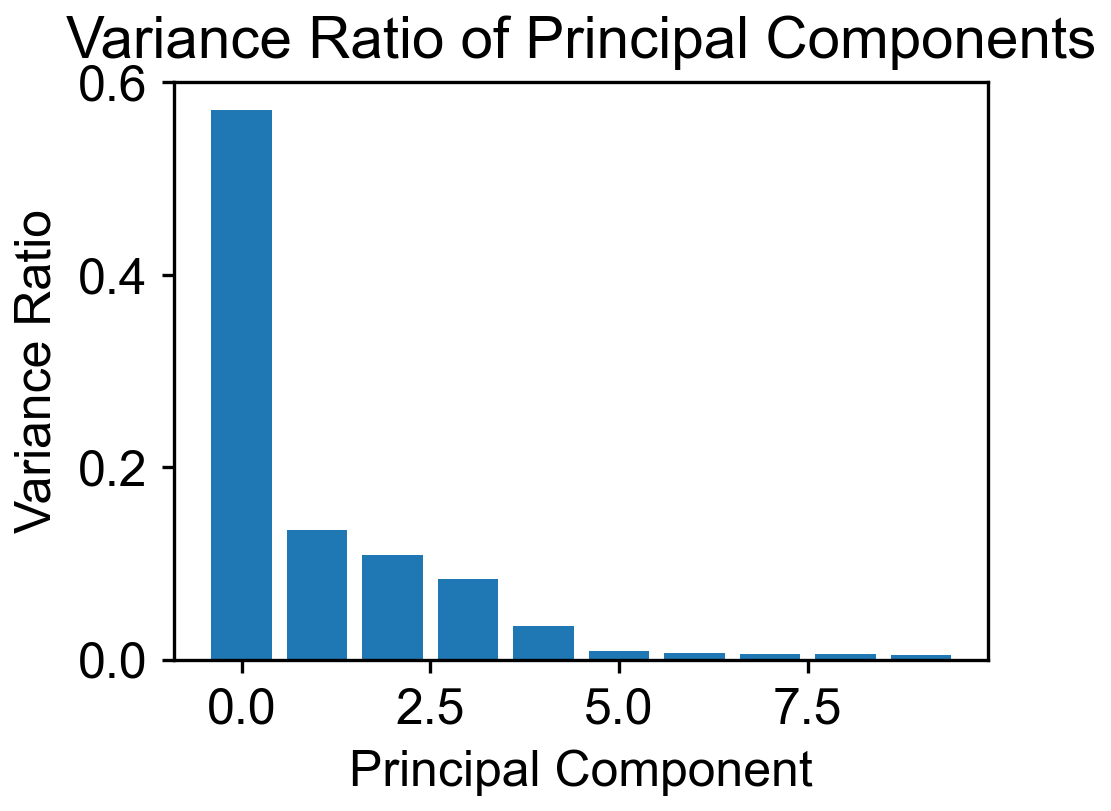

In [52]:
plt.bar(range(soap_pca.shape[1]), pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("Variance Ratio of Principal Components")
plt.show()

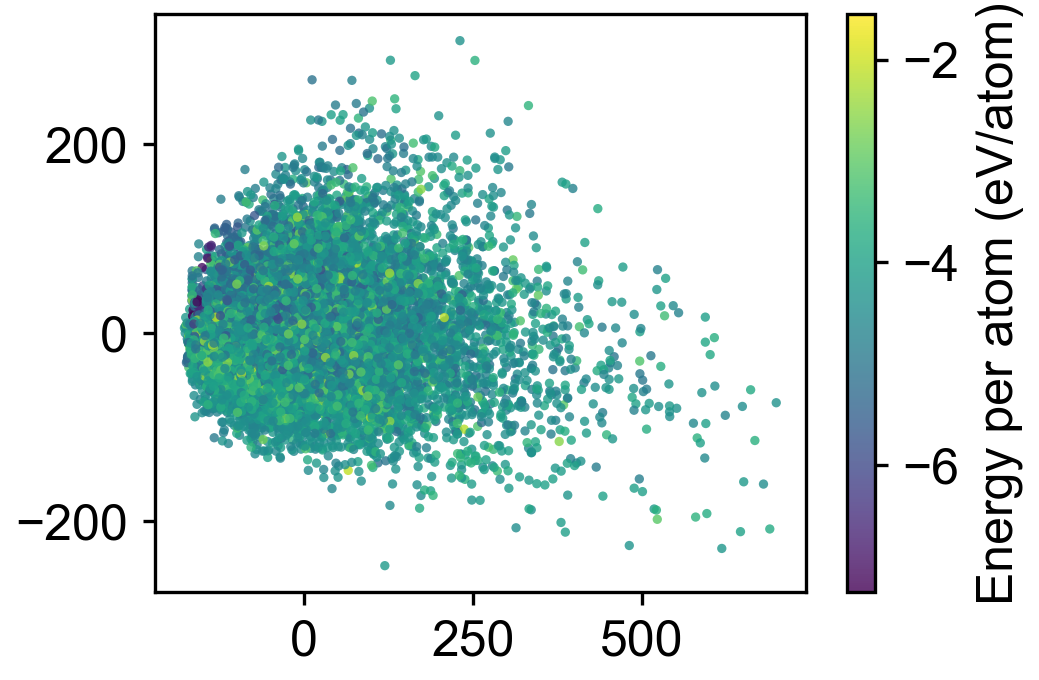

In [111]:
plt.scatter(soap_pca[:,0], soap_pca[:,1], s=5, alpha=0.8, c=energies, cmap="viridis", edgecolors="none")
plt.colorbar(label="Energy per atom (eV/atom)")

### t-SNE reduction

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

**Definition:**  
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique primarily used for visualizing high-dimensional data in 2 or 3 dimensions. It is especially effective at preserving local structure and revealing clusters in data.

---

**Algorithm Overview:**  
Given a dataset $X$ with $n$ samples and $d$ features:

1. **Pairwise Similarities in High Dimensions:**  
    - Compute pairwise similarities $p_{ij}$ between points using a Gaussian kernel:
      $$
      p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
      $$
    - Symmetrize:
      $$
      p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
      $$

2. **Pairwise Similarities in Low Dimensions:**  
    - Map each high-dimensional point $x_i$ to a low-dimensional point $y_i$.
    - Compute similarities $q_{ij}$ using a Student-t distribution (heavy-tailed):
      $$
      q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
      $$

3. **Minimize Divergence:**  
    - Minimize the Kullback-Leibler (KL) divergence between $p_{ij}$ and $q_{ij}$:
      $$
      C = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
      $$
    - Optimization is performed using gradient descent.

---

**Key Parameters:**
- **Perplexity:** Controls the balance between local and global aspects of the data (typical values: 5–50).
- **n_components:** Number of output dimensions (usually 2 or 3 for visualization).
- **Learning rate:** Step size for optimization.

---

**What Can t-SNE Do?**
- **Visualization:** Reveal clusters and local structure in complex datasets.
- **Nonlinear Reduction:** Captures nonlinear relationships, unlike PCA.
- **Exploratory Analysis:** Useful for understanding data distributions and groupings.

**Limitations:**
- Not suitable for preserving global structure.
- Computationally intensive for large datasets.
- Results can vary with different random seeds and perplexity values.

**Typical Applications:**  
- Visualizing high-dimensional data (e.g., images, molecular descriptors, gene expression).
- Clustering analysis.
- Outlier detection.

**References:**  
- van der Maaten, L., & Hinton, G. (2008). Visualizing Data using t-SNE. *Journal of Machine Learning Research*, 9(Nov), 2579–2605.
- scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [116]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
soap_tsne = tsne.fit_transform(soap_discriptor)

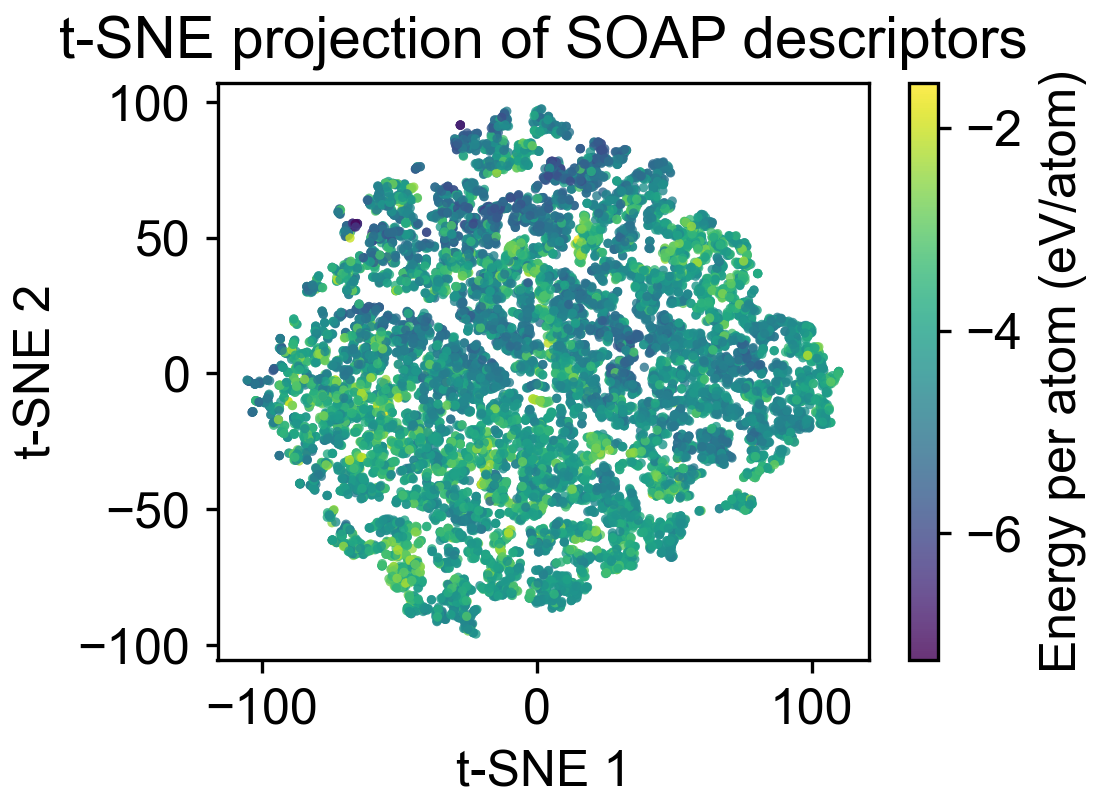

In [118]:
plt.scatter(soap_tsne[:,0], soap_tsne[:,1], s=5, alpha=0.8, c=energies, cmap="viridis", edgecolors="none")
plt.colorbar(label="Energy per atom (eV/atom)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of SOAP descriptors")
plt.show()

## How to choose your training data from the above scatters?

### 1.1 K-means clustering 

In [120]:
# K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(soap_tsne)
clusters

array([2, 3, 5, ..., 6, 7, 0], shape=(14718,), dtype=int32)

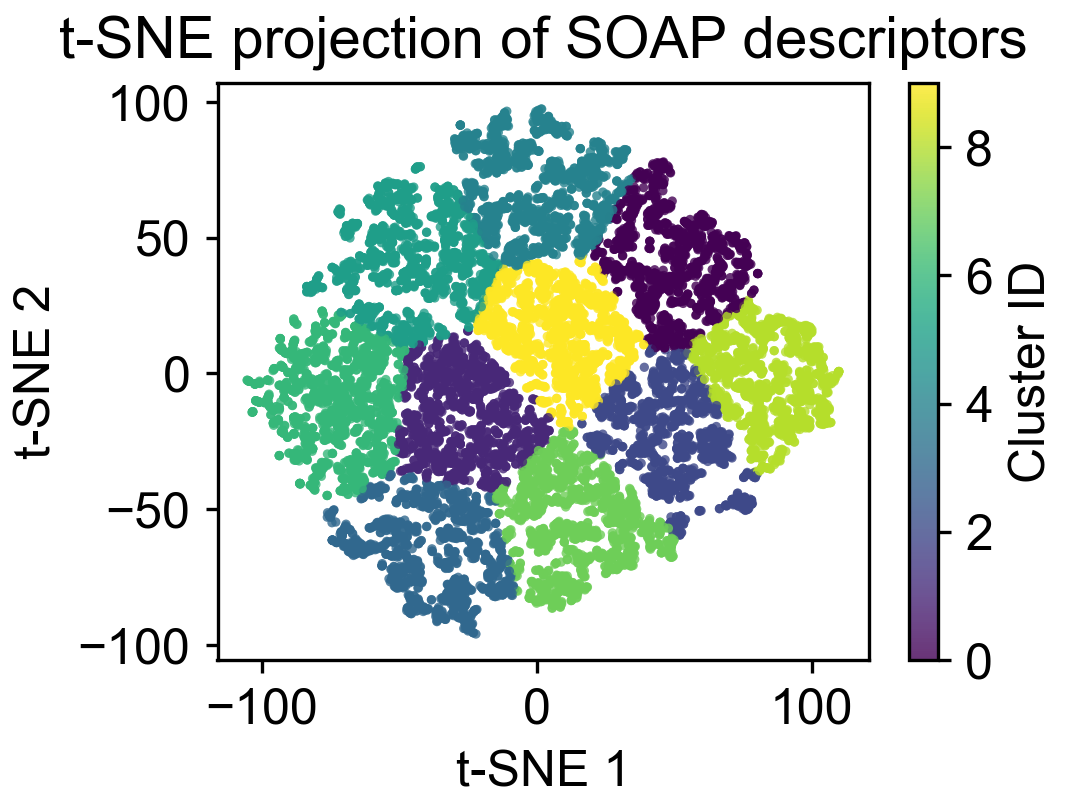

In [122]:
plt.scatter(soap_tsne[:,0], soap_tsne[:,1], s=5, alpha=0.8, c=clusters, cmap="viridis", edgecolors="none")

plt.colorbar(label="Cluster ID")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of SOAP descriptors")
plt.show()

### 1.2 Grid reduction


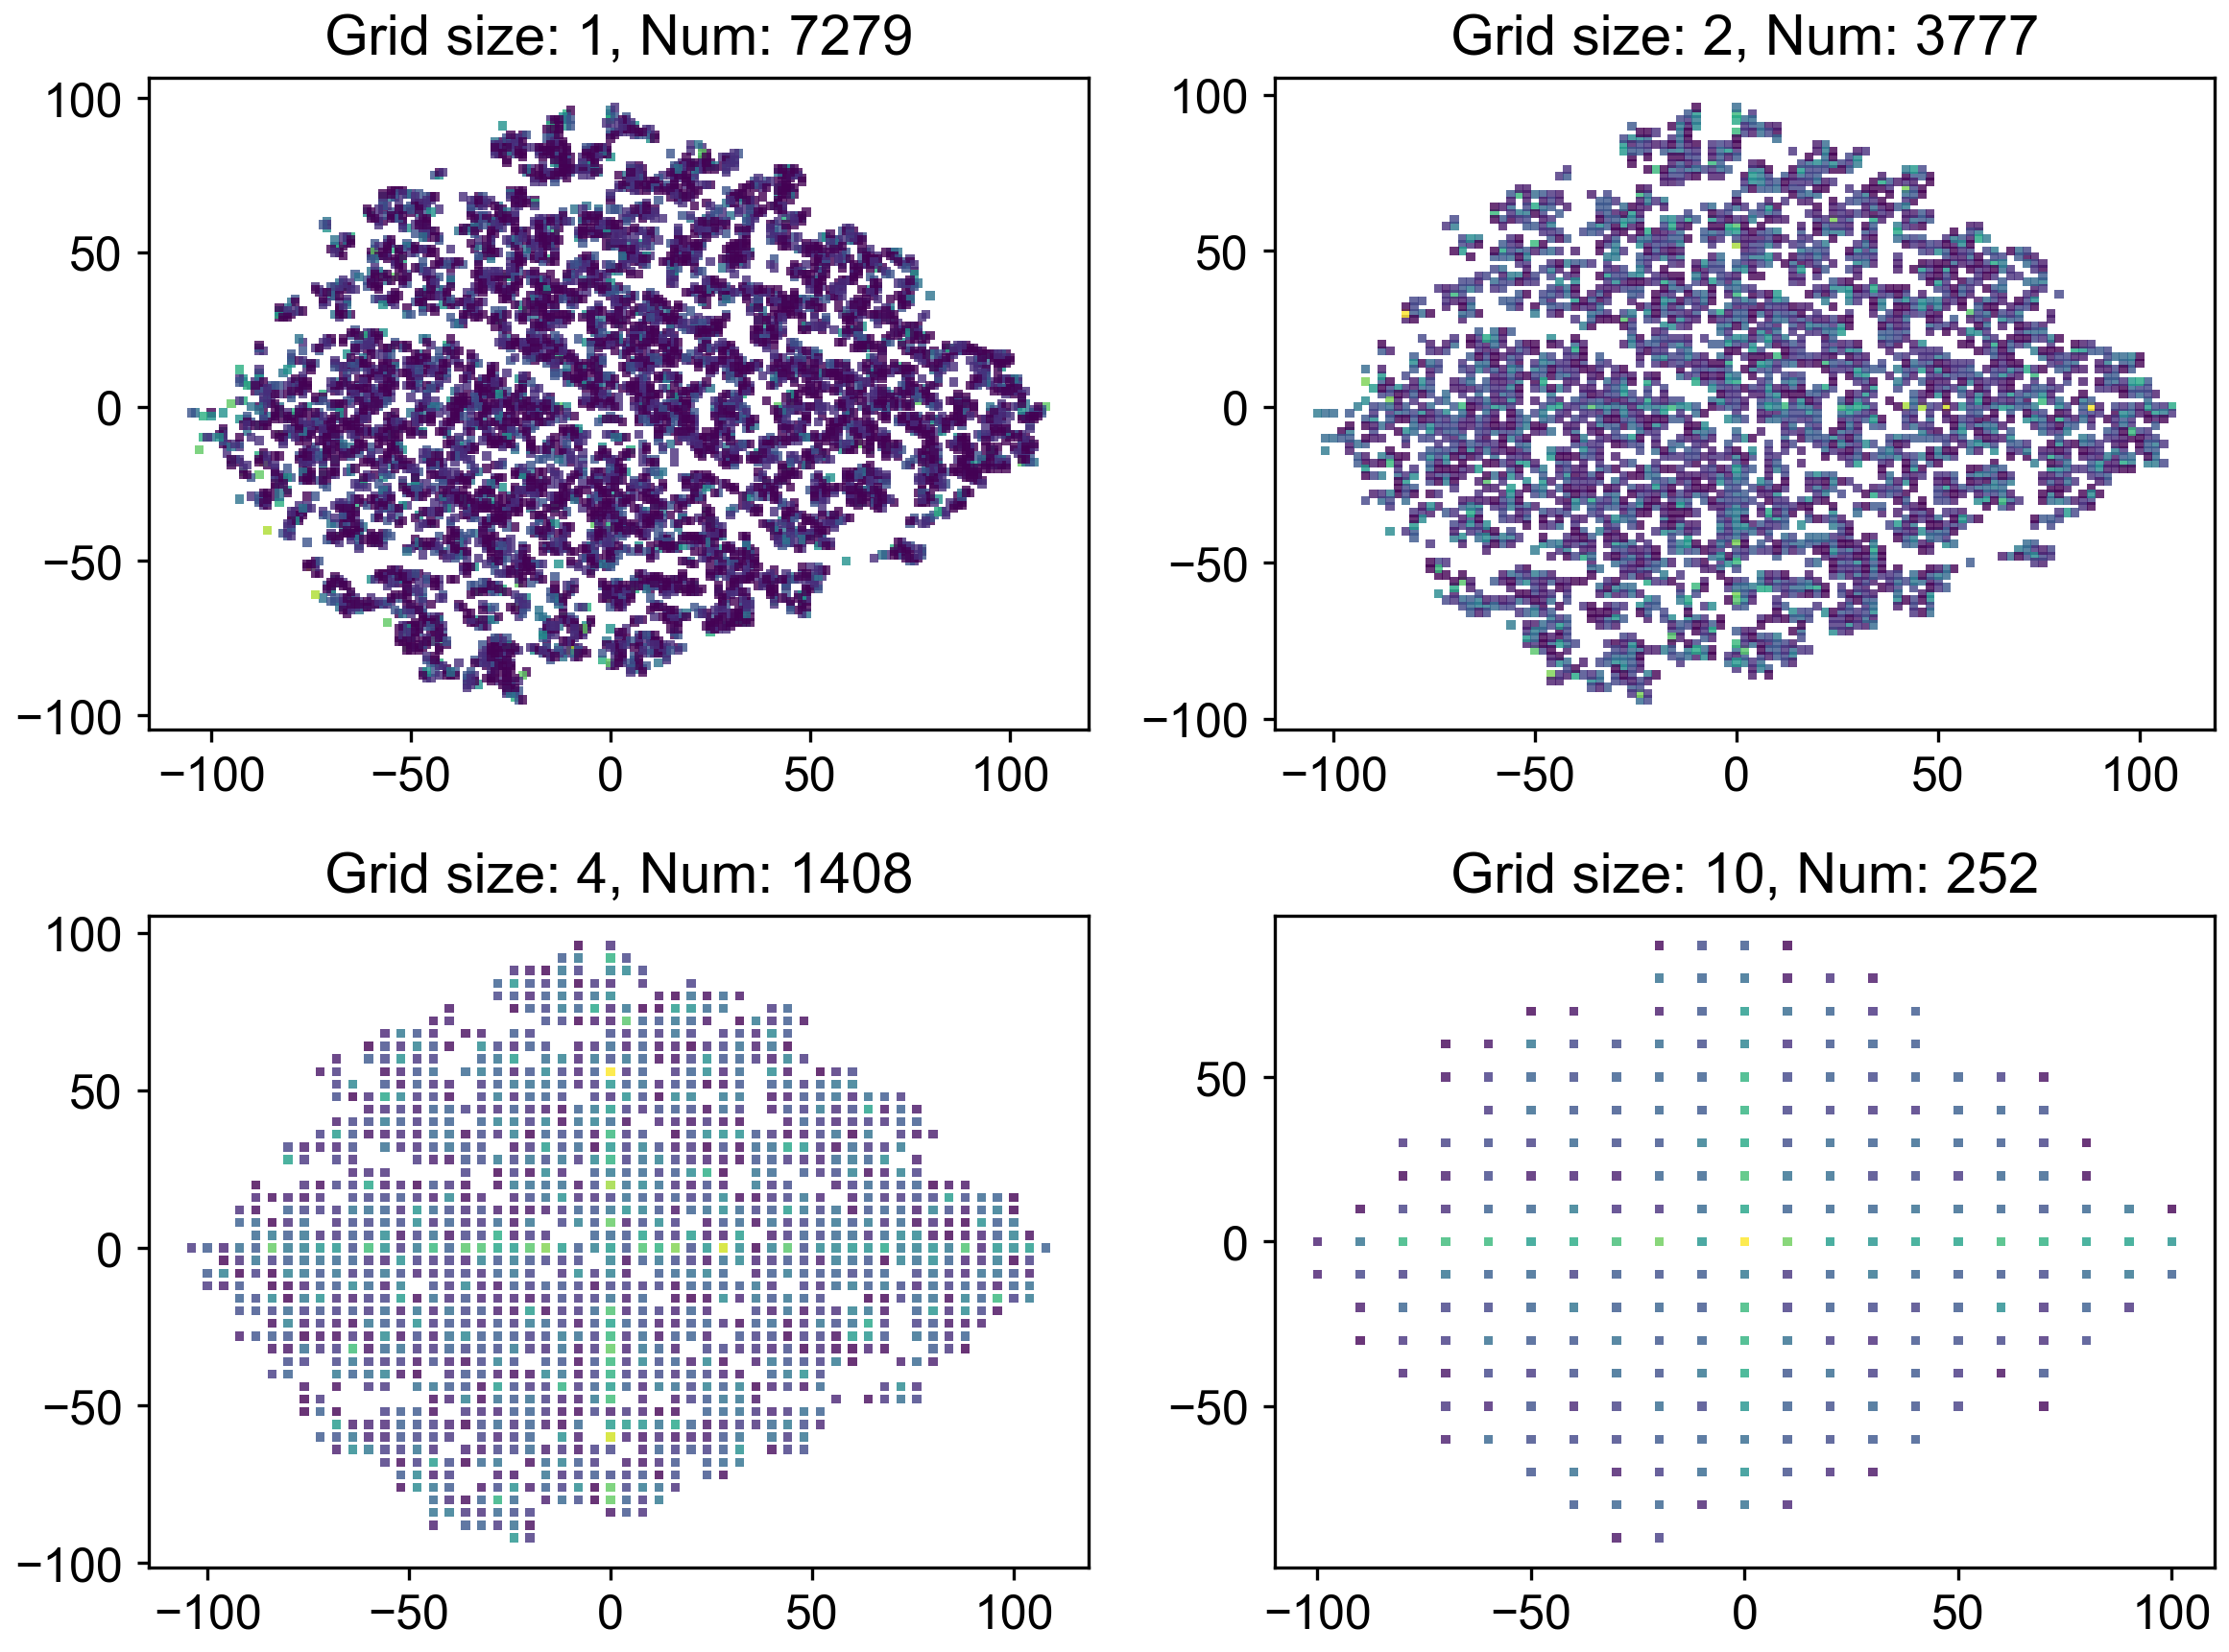

In [141]:
# Grid reduction of dataset
def grid_dataset(data, grid_size):
    """
    Grid the dataset into a fixed size grid
    """
    from collections import defaultdict
    data_grid = (data / grid_size).astype(int)
    grid_dict = defaultdict(list)
    for i, j in enumerate(data_grid):
        grid_dict[f"{j[0]}_{j[1]}"].append(i)
    data_grid = np.array([ikey.split("_") for ikey in grid_dict.keys()], int) * grid_size
    num = np.array([len(grid_dict[ikey]) for ikey in grid_dict.keys()])

    select = np.array([grid_dict[key][0] for key in grid_dict.keys()], int)
    return data_grid, num


grids_list = [1, 2, 4, 10]

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(8, 6))
for i, g in enumerate(grids_list):
    red_grid, red_num = grid_dataset(soap_tsne, g)
    ax[i//2, i%2].scatter(red_grid[:,0], red_grid[:,1], marker="s", s=5, alpha=0.8, c=red_num, cmap="viridis", edgecolors="none")
    ax[i//2, i%2].set_title(f"Grid size: {g}, Num: {len(red_num)}")

### 1.3 Force filtering

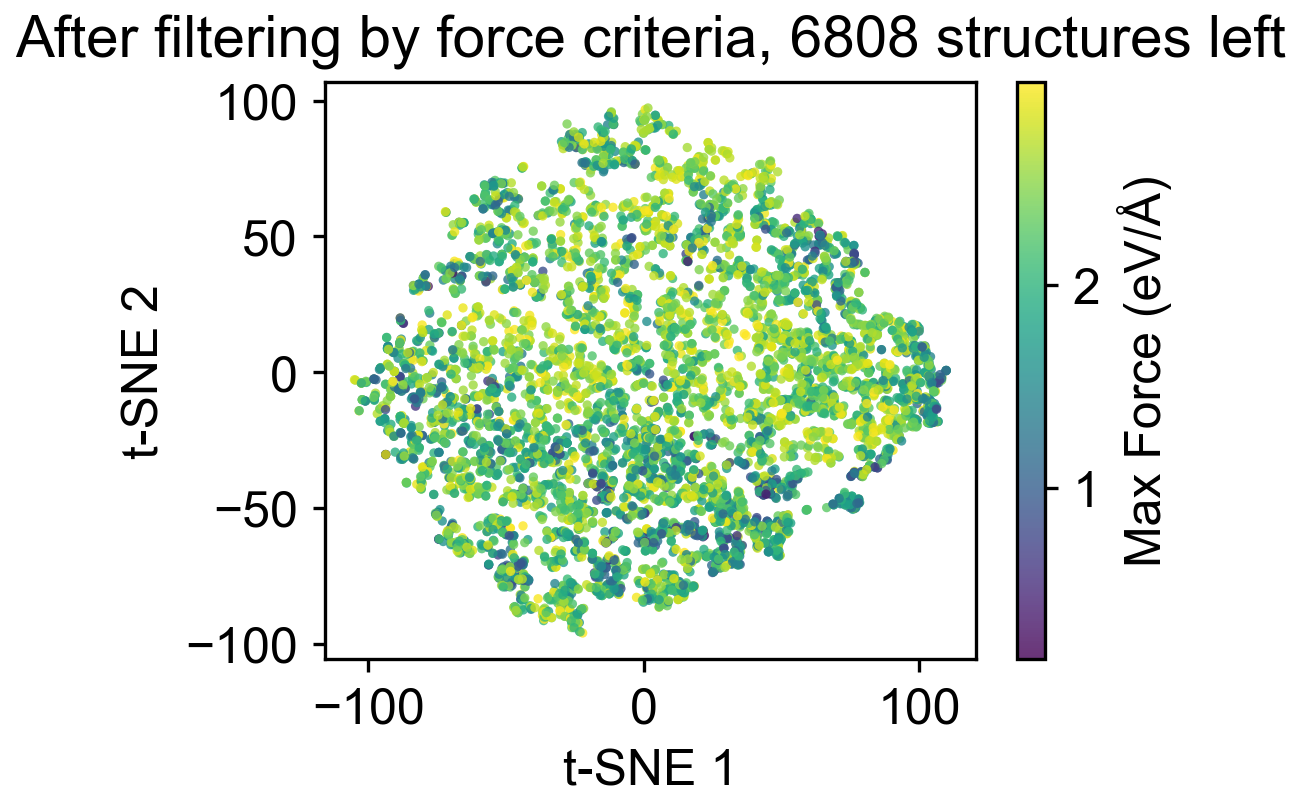

In [169]:
force_criteria = 3  # eV/Å
selected_indices = [i for i, s in enumerate(forces) if np.any(s < force_criteria)]

plt.scatter(soap_tsne[selected_indices][:, 0], soap_tsne[selected_indices][:, 1], s=5, alpha=0.8, c=[np.max(s) for i,s in enumerate(forces) if i in selected_indices], edgecolors="none")
plt.colorbar(label="Max Force (eV/Å)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(f"After filtering by force criteria, {len(selected_indices)} structures left")
plt.show()

### 1.4 Any other method you can try?